In [101]:
"""
Created on March 12, 2025

@author: Zarah Aigner

The following code is used to analyze the spectroscopy spectrum of the atmosphere. In this experiment the principles of the solarspectrum gets
analyzed using an Echelle spectrograph. The goal of the experiment is to identify the weak Fe I lines and then derive teh effective temperature
and then realtive iron abundance.
"""

# importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import configparser
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
plt.rcParams['text.usetex'] = True #LaTeX implementation

# loading the values
file_path_data = "/home/jtilg/uibk/semester6/FP_SS25/daten_bearbeitet.csv"
df = pd.read_csv(file_path_data, delimiter=';', decimal=',', encoding='ISO-8859-1')

lam = df.iloc[:, 0].values
exc_potential = df.iloc[:, 1].values
log_gf = df.iloc[:, 2].values
ew_lambda = pd.to_numeric(df.iloc[:, 3], errors='coerce').values  # Convert to numeric, 'coerce' will replace invalid entries with NaN
ew = pd.to_numeric(df.iloc[:, 4], errors='coerce').values 

# just to check if loading the data workes
print(lam[:5])  # Zeigt die ersten 5 Werte der Wellenlängen an
print(exc_potential[:5])  # Zeigt die ersten 5 Anregungspotenziale an
print(log_gf[:5])
print(ew_lambda[:5])
print(ew[:5])

font1 = {'family':'sans-serif','color':'black','size':12}
font2 = {'family':'sans-serif','color':'black','size':20}


[5383.369 5415.199 5049.82  5367.467 5302.302]
[4.312 4.386 2.279 4.415 3.283]
[ 0.645  0.642 -1.355  0.443 -0.72 ]
[5383.361 5415.192 5049.801 5367.455 5302.294]
[0.166 0.156 0.135 0.127 0.131]


[0.117 0.113 0.106 0.101 0.076 0.085 0.091]
[6252.558 5576.081 6430.843 5014.928 5083.317 5198.696 4924.751]
Anzahl der verwendeten Werte: 143
Fitted Temperature (T): 6106.76 K ± 292.98
Fitted Iron Abundance (N_Fe/N_H): -3.87e+00 ± 1.53e-01


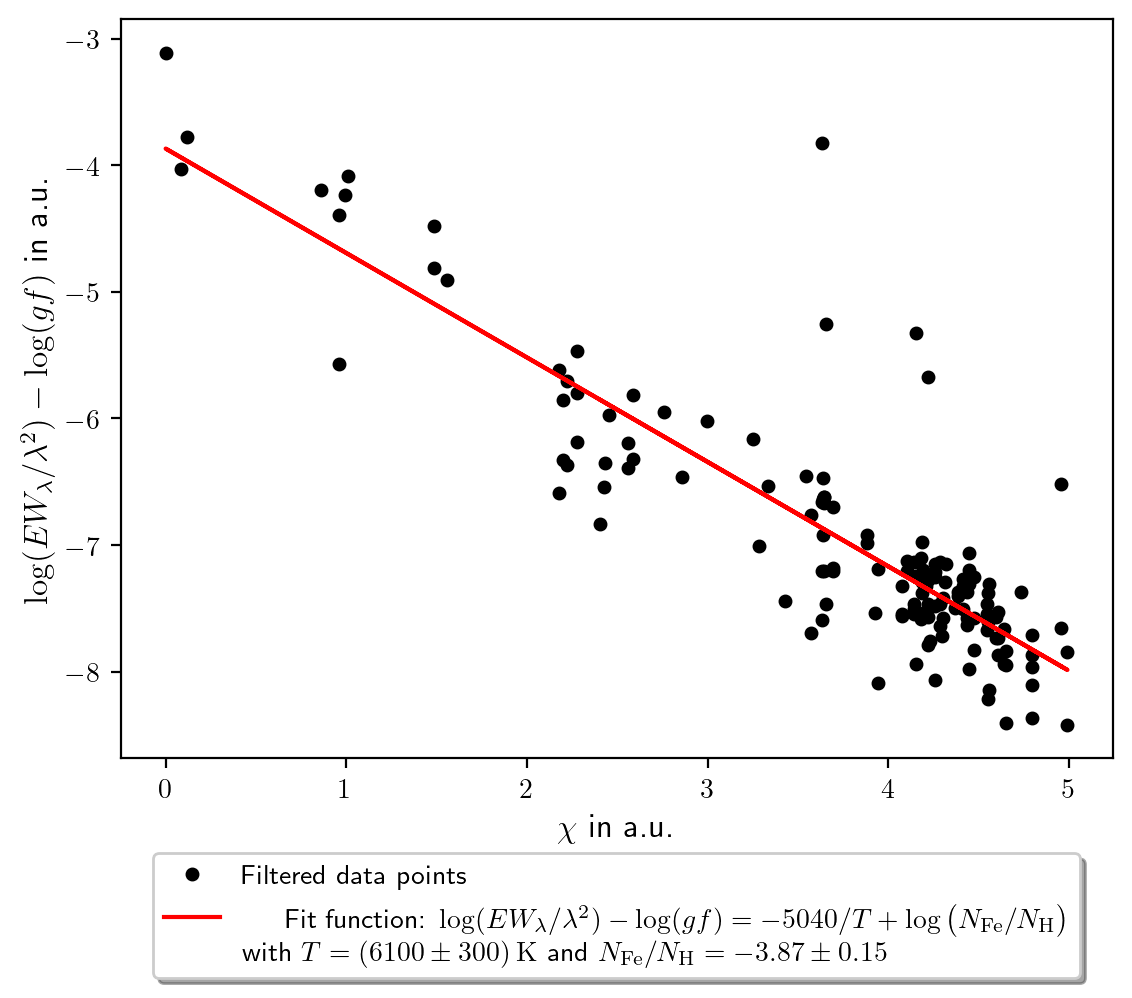

In [102]:
###############################################################################################################################
###############################################################################################################################
# first step: identifying weak lines
"""
In the first step, we need to identify the thin lines, because there each photon reacts with an atom only once.
Therefore we use a boolean mask, to only use EW < 0,12. I then created the first plot which should lead to a linear 
function, by also fitting a linear function onto the datapoints we can determine the effective temperature and the abundance.
In the next step we kick out all the data points which are not in the linear region. 
Then plotting the curve of growth and comparing with the theoretical curve to calculate T and N_Fe/N_H
"""
# filter
mask = ew < 0.12

# storing the filtered data
lam_filtered = lam[mask]
exc_potential_filtered = exc_potential[mask]
log_gf_filtered = log_gf[mask]
ew_lambda_filtered = ew_lambda[mask]
ew_filtered = ew[mask]

# to check if the filter worked
print(ew_filtered[:7])
print(ew_lambda_filtered[:7])
print(f"Anzahl der verwendeten Werte: {len(ew_filtered)}")

# curve of growth
y_values = np.log10(ew_filtered / lam_filtered**2) - np.log10(10**log_gf_filtered)
x_values = exc_potential_filtered 

# linear fit
def linear_fit(chi, T, abundance):
    return -5040 / T * chi + abundance

# perform the linear fit
params, covariance = curve_fit(linear_fit, exc_potential_filtered, y_values)

# extract the fitted parameters (T and abundance)
T_fit = params[0]
abundance_fit = params[1]

# calculate the uncertainities on the parameters
param_errors = np.sqrt(np.diag(covariance))
T_error = param_errors[0]
abundance_error = param_errors[1]

# printing the results
print(f"Fitted Temperature (T): {T_fit:.2f} K ± {T_error:.2f}")
print(f"Fitted Iron Abundance (N_Fe/N_H): {abundance_fit:.2e} ± {abundance_error:.2e}")

# plotting the growth curve
plt.figure(dpi= 200)
plt.plot(x_values, y_values, 'o', label=r'Filtered data points', color='black', ms=4)

# Plot the linear fit
chi_values = exc_potential_filtered
fitted_y_values = linear_fit(chi_values, T_fit, abundance_fit)
plt.plot(chi_values, fitted_y_values, label=r'Fit function: $\log(EW_{\lambda}/\lambda^2) - \log(gf) = - 5040/T + \log{\bigl( N_\mathrm{Fe} / N_\mathrm{H} \bigr)}$ \\ with $T= (6100 \pm 300)\: \mathrm{K}$ and $N_\mathrm{Fe} / N_\mathrm{H}= -3.87 \pm 0.15$', color='red')

plt.xlabel(r'$\chi$ in a.u.', fontdict=font1)
plt.ylabel(r'$\log(EW_{\lambda}/\lambda^2) - \log(gf)$ in a.u.', fontdict=font1)
#plt.title('Curve of growth for weak Fe I lines with linear fit')
#plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True)
plt.show()

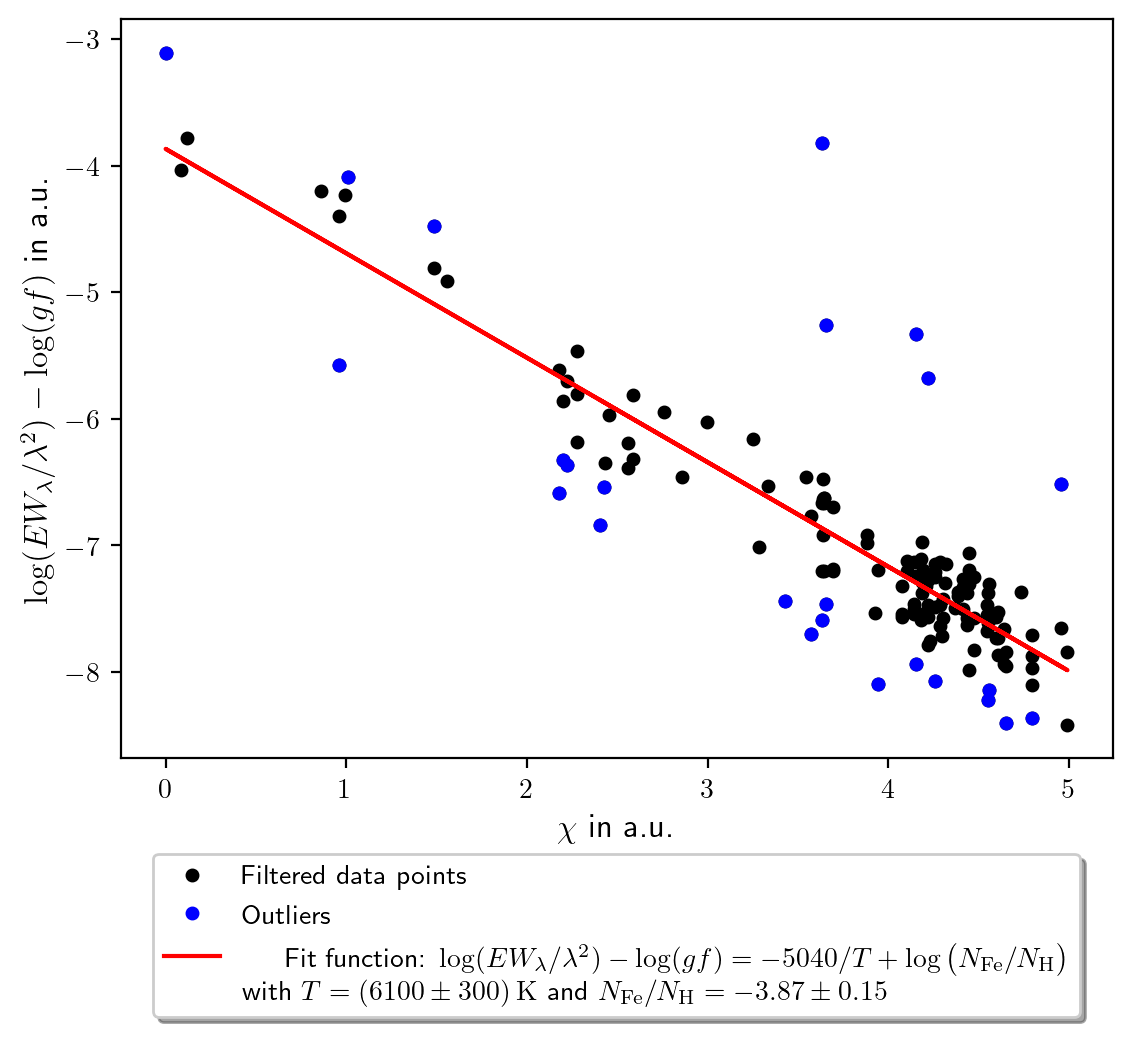

In [107]:
################################################################################################################################
# kicking out some datapoints
tolerance = 0.5

deviation = np.abs(y_values - fitted_y_values)

not_linear_mask = deviation > tolerance

"""
lam_fitted = lam_filtered[~not_linear_mask]
ew_fitted = ew_filtered[~not_linear_mask]
log_gf_fitted = log_gf_filtered[~not_linear_mask]
exc_potential_fitted = exc_potential_filtered[~not_linear_mask]
ew_lambda_fitted = ew_lambda_filtered[~not_linear_mask]

# not in the linear region points
lam_non_linear = lam_filtered[not_linear_mask]
ew_non_linear = ew_filtered[not_linear_mask]
log_gf_non_linear = log_gf_filtered[not_linear_mask]
exc_potential_non_linear = exc_potential_filtered[not_linear_mask]
ew_lambda_non_linear = ew_lambda_filtered[not_linear_mask]
"""

# Plotting the results: Mark points outside the linear region in red
plt.figure(dpi= 200)
plt.plot(x_values, y_values, 'o', label=r'Filtered data points', color='black', ms=4)
#plt.plot(x_values, y_values, 'o', color='black')
plt.plot(x_values[not_linear_mask], y_values[not_linear_mask], 'o', label=r'Outliers', color='blue', ms=4)
# Plot the linear fit
plt.plot(chi_values, fitted_y_values, label=r'Fit function: $\log(EW_{\lambda}/\lambda^2) - \log(gf) = - 5040/T + \log{\bigl( N_\mathrm{Fe} / N_\mathrm{H} \bigr)}$ \\ with $T= (6100 \pm 300)\: \mathrm{K}$ and $N_\mathrm{Fe} / N_\mathrm{H}= -3.87 \pm 0.15$', color='red')

# Labels and title
plt.xlabel(r'$\chi $ in a.u.', fontsize=12)
plt.ylabel(r'$\log(EW_{\lambda}/\lambda^2) - \log(gf)$ in a.u.', fontsize=12)
#plt.title(r'Curve of growth for weak Fe I lines with outliers marked', fontsize=14)

#plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True)
#plt.legend()
plt.show()

lam_fitted = lam_filtered[~not_linear_mask]
ew_fitted = ew_filtered[~not_linear_mask]
log_gf_fitted = log_gf_filtered[~not_linear_mask]
exc_potential_fitted = exc_potential_filtered[~not_linear_mask]
ew_lambda_fitted = ew_lambda_filtered[~not_linear_mask]

Min. lam_fitted: 4802.88
Min. log_gf_fitted: -5.023
Abundance fit: -3.867628675507039
Min. exc_potential_fitted: 0.087


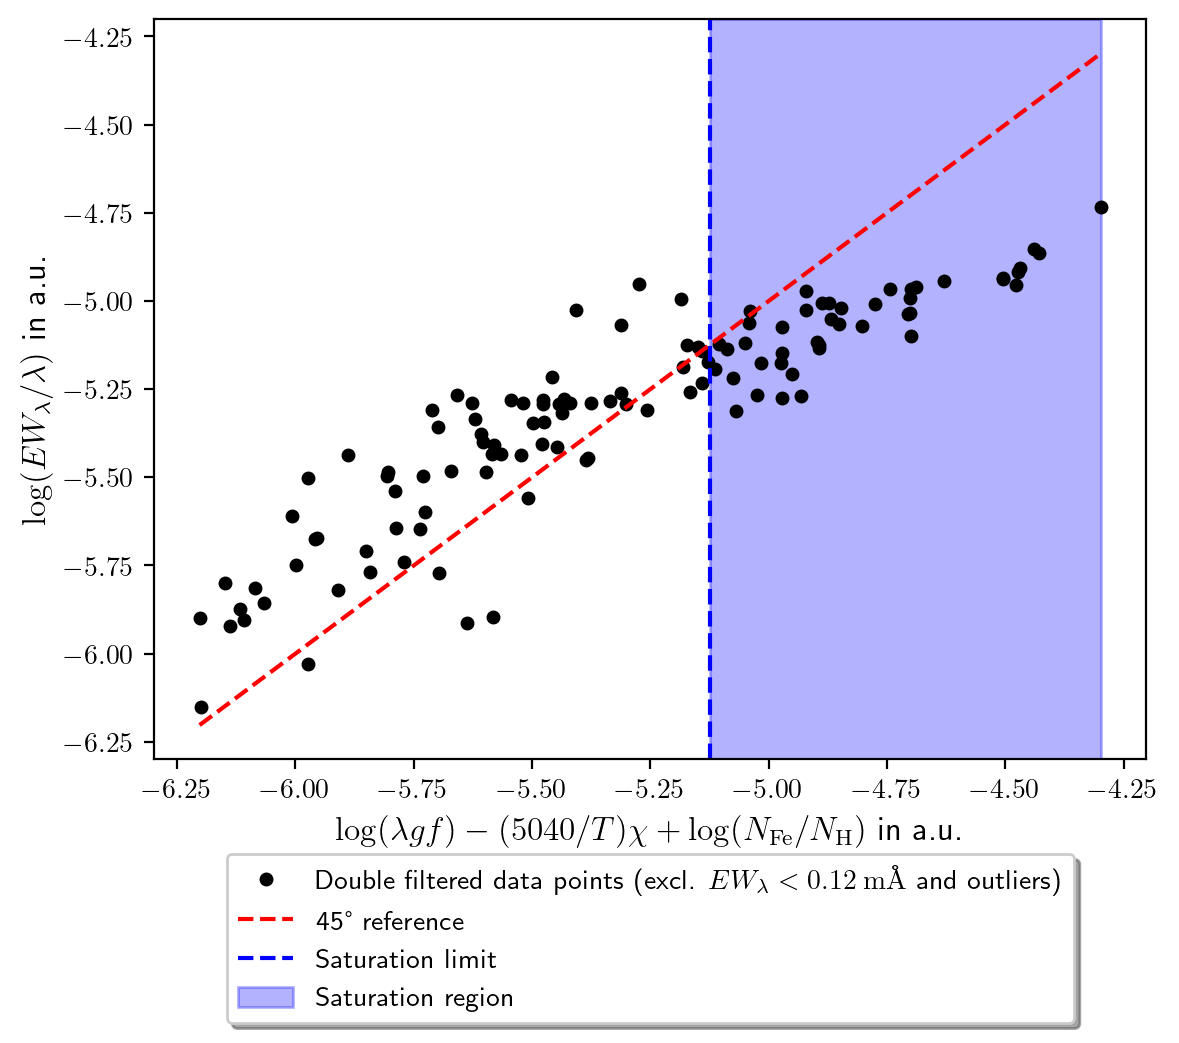

In [104]:
############################################################################################################################
###############################################################################################################################
# second step
"""
In the second exercise we now plot the curve of growth with the calculated T and abundance. Then we compare the theoretical curve of growth 
with our calculated curve of growth. So we can cancel out all the points wich still present the saturation
"""
print("Min. lam_fitted:", np.min(lam_fitted))
print("Min. log_gf_fitted:", np.min(log_gf_fitted))
print("Abundance fit:", abundance_fit)
print("Min. exc_potential_fitted:", np.min(exc_potential_fitted))

x_values_2 = np.log10(lam_fitted) + log_gf_fitted - (5040 / T_fit) * exc_potential_fitted + abundance_fit
y_values_2 = np.log10(ew_fitted / lam_fitted)

#x_values_2 = np.log10(10**abundance_fit) - 5040 / T_fit * exc_potential_fitted
#y_values_2 = np.log10(ew_fitted / lam_fitted) - np.log10(lam_fitted * 10**log_gf_fitted)
# Erstelle die gestrichelte 45°-Linie
min_x, max_x = np.min(x_values_2), np.max(x_values_2)
min_y, max_y = np.min(y_values_2), np.max(y_values_2)
x_lim = -5.125


plt.figure(dpi= 200)
plt.plot(x_values_2, y_values_2, 'o', label=r'Double filtered data points (excl. $EW_\lambda < 0.12 \: \mathrm{m\r{A}}$ and outliers)', color='black', ms=4)
plt.plot([min_x, max_x], [min_x, max_x], '--', color='red', label=r'45° reference')
plt.axvline(x=x_lim, color='blue', linestyle='--', label=r'Saturation limit')
plt.axvspan(x_lim, np.max(x_values_2), color='blue', alpha=0.3, label=r'Saturation region')
plt.xlabel(r'$\log(\lambda gf) - (5040 / T) \chi + \log(N_\mathrm{Fe}/N_\mathrm{H})$ in a.u.', fontsize=12)
plt.ylabel(r'$\log(EW_{\lambda}/\lambda)$ in a.u.', fontsize=12)
#plt.title(r'Curve of growth for weak Fe I lines without saturation points')
#plt.grid(True)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True)
#plt.legend()
plt.show()

lam_fitted_2 = lam_fitted[x_values_2 > x_lim]
exc_potential_fitted_2 = exc_potential_fitted[x_values_2 > x_lim]
log_gf_fitted_2 = log_gf_fitted[x_values_2 > x_lim]
ew_lambda_fitted_2 = ew_lambda_fitted[x_values_2 > x_lim]
ew_fitted_2 = ew_fitted[x_values_2 > x_lim]

Fitted Temperature (T): 6323.81 K ± 203.50
Fitted Iron Abundance (N_Fe/N_H): -4.22e+00 ± 1.01e-01


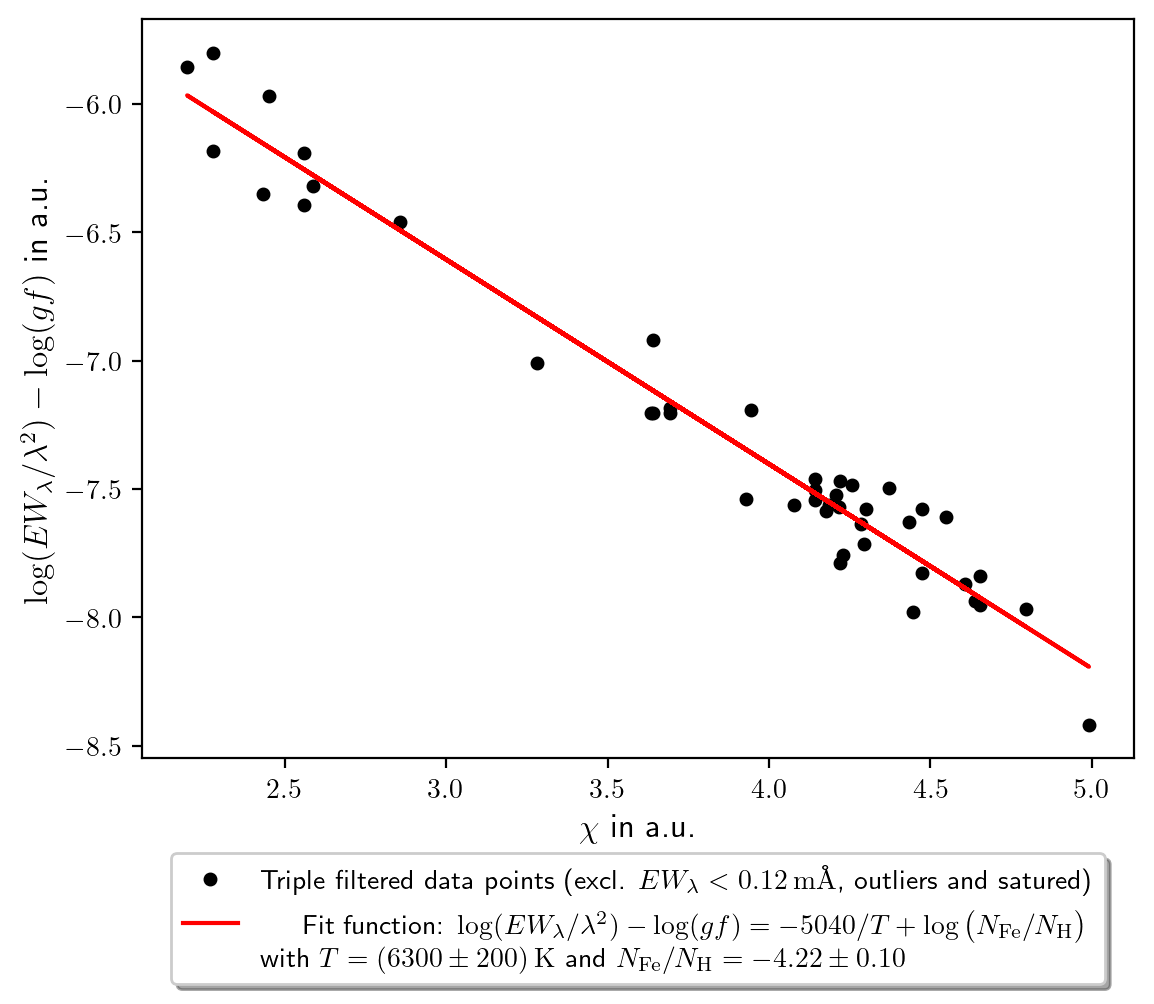

In [105]:
###############################################################################################################################################
# now plotting the initial plot with the two times fitted data
y_values_3 = np.log10(ew_fitted_2/ lam_fitted_2**2) - np.log10(10**log_gf_fitted_2)
x_values_3 = exc_potential_fitted_2

# linear fit
def linear_fit(chi, T, abundance):
    return -5040 / T * chi + abundance

# perform the linear fit
params, covariance = curve_fit(linear_fit, exc_potential_fitted_2, y_values_3)

# extract the fitted parameters (T and abundance)
T_fit_3 = params[0]
abundance_fit_3 = params[1]

# calculate the uncertainities on the parameters
param_errors_3 = np.sqrt(np.diag(covariance))
T_error_3 = param_errors_3[0]
abundance_error_3 = param_errors_3[1]

# printing the results
print(f"Fitted Temperature (T): {T_fit_3:.2f} K ± {T_error_3:.2f}")
print(f"Fitted Iron Abundance (N_Fe/N_H): {abundance_fit_3:.2e} ± {abundance_error_3:.2e}")

# plotting the growth curve
plt.figure(dpi= 200)
plt.plot(x_values_3, y_values_3, 'o', label=r'Triple filtered data points (excl. $EW_\lambda < 0.12 \: \mathrm{m\r{A}}$, outliers and satured)', color='black', ms=4)
#plt.plot(x_values_3, y_values_3, 'o')

# Plot the linear fit
chi_values_3 = exc_potential_fitted_2
fitted_y_values_3 = linear_fit(chi_values_3, T_fit_3, abundance_fit_3)
plt.plot(chi_values_3, fitted_y_values_3, label=r'Fit function: $\log(EW_{\lambda}/\lambda^2) - \log(gf) = - 5040/T + \log{\bigl( N_\mathrm{Fe} / N_\mathrm{H} \bigr)}$ \\ with $T= (6300 \pm 200)\: \mathrm{K}$ and $N_\mathrm{Fe} / N_\mathrm{H}= -4.22 \pm 0.10$', color='red')

plt.xlabel(r'$\chi$ in a.u.', fontdict=font1)
plt.ylabel(r'$\log(EW_{\lambda}/\lambda^2) - \log(gf)$ in a.u.', fontdict=font1)
#plt.title(r'Curve of growth for weak Fe I lines with linear fit after throwing out seperation values')
#plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.11), fancybox=True, shadow=True)
#plt.legend()
plt.show()